In [1]:
import numpy as np
import matplotlib.pyplot as plt

X = np.loadtxt('sindata.csv', delimiter=',')

In [2]:
# 计算多元高斯分布的概率密度的对数
def log_gaussian_prob(x, mu, sigma):
    d = x.shape[-1]
    det = np.linalg.det(sigma)
    diff = x - mu
    # 由于x可能包含多个样本
    # x.T @ inv(sigma) @ x 的第二个乘法只需要保留前后样本一致的部分，
    # 所以第二个乘法用点乘再求和代替
    # 此外，由于数据存储维度的问题，这里的转置和上面公式中的转置相反
    log_prob = -d / 2 * np.log(2 * np.pi) - 0.5 * np.log(det) \
             - 0.5 * np.sum(diff @ np.linalg.inv(sigma) * diff, axis=-1)
    return log_prob

In [3]:
from sklearn.cluster import KMeans
from scipy.special import logsumexp

class GMM:

    def __init__(self, n_components=2, eps=1e-4, max_iter=100, init='random'):
        # n_components：GMM中高斯分布的数目
        # eps：迭代精度，当对数似然的变化小于eps时迭代终止
        # max_iter：最大迭代次数
        # init：初始化方法，random或kmeans
        self.k = n_components
        self.eps = eps
        self.max_iter = max_iter
        self.init = init
        self.phi = None # 隐变量的先验分布，即每个高斯分布的占比
        self.means = None # 每个高斯分布的均值
        self.covs = None # 每个高斯分布的协方差

    def EM_fit(self, X):
        # 用EM算法求解GMM的参数
        # 参数初始化
        if self.init == 'random': 
            self._random_init_params(X) 
        elif self.init == 'kmeans':
            self._kmeans_init_params(X)
        else:
            raise NotImplementedError
        ll = self._calc_log_likelihood(X) # 当前的对数似然
        n, d = X.shape
        # 开始迭代
        qz = np.zeros((n, self.k)) # z的后验分布
        for t in range(self.max_iter):
            # E步骤，更新后验分布
            for i in range(self.k):
                # 计算样本属于第i类的概率
                log_prob = log_gaussian_prob(X, self.means[i], self.covs[i])
                qz[:, i] = self.phi[i] * np.exp(log_prob)
            # 归一化
            qz = qz / np.sum(qz, axis=1).reshape(-1, 1)

            # M步骤，统计更新参数，最大化对数似然
            self.phi = np.sum(qz, axis=0) / n # 更新隐变量分布
            for i in range(self.k):
                # 更新均值
                self.means[i] = np.sum(qz[:, i, None] * X, axis=0) \
                    / n / self.phi[i]
                # 更新协方差
                diff = X - self.means[i]
                self.covs[i] = (qz[:, i, None] * diff).T @ diff \
                    / (n - 1) / self.phi[i]
            
            # 判断对数似然是否收敛
            new_ll = self._calc_log_likelihood(X)
            # assert new_ll >= ll, new_ll
            if new_ll - ll <= self.eps:
                break
            ll = new_ll
            
    def _calc_log_likelihood(self, X):
        # 计算当前的对数似然
        ll = 0
        for i in range(self.k):
            log_prob = log_gaussian_prob(X, self.means[i], self.covs[i])
            # 用logsumexp简化计算
            # 该函数底层对对数-求和-指数形式的运算做了优化
            ll += logsumexp(log_prob + np.log(self.phi[i]))
        return ll

    def _random_init_params(self, X):
        self.phi = np.random.uniform(0, 1, self.k) # 随机采样phi
        self.phi /= np.sum(self.phi)
        self.means = np.random.uniform(np.min(X), np.max(X), 
            (self.k, X.shape[1])) # 随机采样均值
        self.covs = np.random.uniform(-1, 1, 
            (self.k, X.shape[1], X.shape[1])) # 随机采样协方差
        self.covs += np.eye(X.shape[1]) * X.shape[1] # 加上维度倍的单位矩阵

    def _kmeans_init_params(self, X):
        # 用Kmeans算法初始化参数
        # 简单起见，我们直接调用sklearn库中的Kmeans方法
        kmeans = KMeans(n_clusters=self.k, init='random', 
            n_init='auto', random_state=0).fit(X)
        # 计算高斯分布占比
        data_in_cls = np.bincount(kmeans.labels_, minlength=self.k)
        self.phi = data_in_cls / len(X)
        # 计算均值和协方差
        self.means = np.zeros((self.k, X.shape[1]))
        self.covs = np.zeros((self.k, X.shape[1], X.shape[1]))
        for i in range(self.k):
            # 取出属于第i类的样本
            X_i = X[kmeans.labels_ == i]
            self.means[i] = np.mean(X_i, axis=0)
            diff = X_i - self.means[i]
            self.covs[i] = diff.T @ diff / (len(X_i) - 1)

In [5]:
import matplotlib as mpl

def plot_elipses(gmm, ax):
    # 绘制椭圆
    # gmm：GMM模型
    # ax：matplotlib的画布
    covs = gmm.covs
    for i in range(len(covs)):
        # 计算椭圆参数
        cov = covs[i][:2, :2]
        v, w = np.linalg.eigh(cov)
        u = w[0] / np.linalg.norm(w[0])
        ang = np.arctan2(u[1], u[0])
        ang = ang * 180 / np.pi
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        # 设置椭圆的绘制参数
        # facecolor和edgecolor分别是填充颜色和边缘颜色
        # 可以自由调整
        elp = mpl.patches.Ellipse(gmm.means[i, :2], v[0], v[1], 
            angle=180 + ang, facecolor='orange', edgecolor='none')
        elp.set_clip_box(ax.bbox)
        # 设置透明度
        elp.set_alpha(0.5)
        ax.add_artist(elp)

TypeError: '<=' not supported between instances of 'str' and 'int'

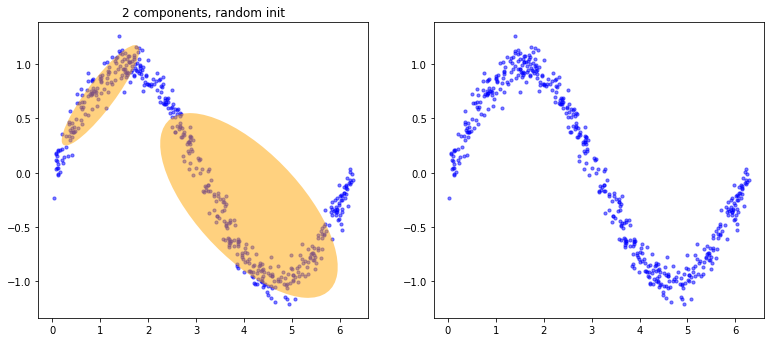

In [6]:
# 超参数
max_iter = 100
eps = 1e-4
np.random.seed(0)

n_components = [2, 3, 5, 10]
inits = ['random', 'kmeans']
fig = plt.figure(figsize=(13, 25))
for i in range(8):
    ax = fig.add_subplot(4, 2, i + 1)
    # 绘制原本的数据点
    ax.scatter(X[:, 0], X[:, 1], color='blue', s=10, alpha=0.5)
    # 初始化并拟合GMM
    k = n_components[i // 2]
    init = inits[i % 2]
    gmm = GMM(k, eps, max_iter, init)
    gmm.EM_fit(X)
    # 绘制椭圆
    plot_elipses(gmm, ax)
    ax.set_title(f'{k} components, {init} init')
plt.show()